In [ ]:
# ---------------------------
# 1. Imports & Setup
# ---------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import torch
import shutil

In [ ]:
# Set global constants
IMAGE_SIZE = (224, 224)
YOLO_IMAGE_SIZE = 640
BATCH_SIZE = 32
DATASET_PATH = "/content/drive/MyDrive/Deteksi Stunting.v2i"

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1)
]

In [ ]:
# ---------------------------
# 2. Preprocessing & Dataset Loading
# ---------------------------

def load_dataset():
    datagen = ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
        os.path.join(DATASET_PATH, 'train'),
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = datagen.flow_from_directory(
        os.path.join(DATASET_PATH, 'val'),
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = datagen.flow_from_directory(
        os.path.join(DATASET_PATH, 'test'),
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

In [ ]:
train_generator, val_generator, test_generator = load_dataset()

Found 1298 images belonging to 2 classes.
Found 372 images belonging to 2 classes.
Found 186 images belonging to 2 classes.


In [ ]:
# ---------------------------
# 3. VGGNet Model
# ---------------------------

def train_vggnet(train_generator, val_generator, test_generator):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        callbacks=callbacks
    )

    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")

    test_preds = model.predict(test_generator)
    y_pred = np.argmax(test_preds, axis=1)
    y_true = test_generator.classes

    return {
        "val_accuracy": history.history['val_accuracy'],
        "val_loss": history.history['val_loss'],
        "y_true": y_true,
        "y_pred": y_pred
    }

In [ ]:
vgg_metrics = train_vggnet(train_generator, val_generator, test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-9-6d886286901e>", line 1, in <cell line: 0>

  File "<ipython-input-8-50873d66182f>", line 21, in train_vggnet

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_2003]

In [ ]:
!mv /content/best_model.h5 /content/best_model_VGG16.h5

In [ ]:
# ---------------------------
# 4. ResNet50 Model
# ---------------------------

def train_resnet50():
    print("Training ResNet50...")
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator = datagen.flow_from_directory(
        os.path.join(DATASET_PATH, 'train'),
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = datagen.flow_from_directory(
        os.path.join(DATASET_PATH, 'val'),
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = datagen.flow_from_directory(
        os.path.join(DATASET_PATH, 'test'),
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        callbacks=callbacks
    )

    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")

    test_preds = model.predict(test_generator)
    y_pred = np.argmax(test_preds, axis=1)
    y_true = test_generator.classes

    return {
        "val_accuracy": history.history['val_accuracy'],
        "val_loss": history.history['val_loss'],
        "y_true": y_true,
        "y_pred": y_pred
    }

In [ ]:
resnet_metrics = train_resnet50()

Training ResNet50...
Found 1298 images belonging to 2 classes.
Found 372 images belonging to 2 classes.
Found 186 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8938 - loss: 0.3529

41/41 ━━━━━━━━━━━━━━━━━━━━ 44s 776ms/step - accuracy: 0.8948 - loss: 0.3501 - val_accuracy: 0.9597 - val_loss: 0.0922 - learning_rate: 0.0010
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9579 - loss: 0.1130

41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 435ms/step - accuracy: 0.9579 - loss: 0.1133 - val_accuracy: 0.9785 - val_loss: 0.0736 - learning_rate: 0.0010
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9775 - loss: 0.0621

41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 469ms/step - accuracy: 0.9775 - loss: 0.0624 - val_accuracy: 0.9785 - val_loss: 0.0683 - learning_rate: 0.0010
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 394ms/step - accuracy: 0.9828 - loss: 0.0443 - val_accuracy: 0.9651 - val_loss: 0.0784 - learning_rate: 0.0010
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 432ms/step - accuracy: 0.9750 - loss: 0.0553 - val_accuracy: 0.9651 - val_loss: 0.0805 - learning_rate: 0.0010
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9814 - loss: 0.0476
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 389ms/step - accuracy: 0.9814 - loss: 0.0476 - val_accuracy: 0.9677 - val_loss: 0.1068 - learning_rate: 0.0010
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9221 - loss: 0.1491
Test Accuracy: 0.94, Test Loss: 0.14
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 923ms/step


In [ ]:
!mv /content/best_model.h5 /content/best_model_ResNet50.h5

In [ ]:
!mv /content/best_model_VGG16.h5 /content/drive/MyDrive/data/results/best_model_VGG16.h5
!mv /content/best_model_ResNet50.h5 /content/drive/MyDrive/data/results/best_model_ResNet50.h5

In [ ]:
!pip install ultralytics
from ultralytics import YOLO
# IMPORTANT: Do NOT restart session after running the code

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO('yolov8n-cls.pt')

100%|██████████| 5.31M/5.31M [00:00<00:00, 95.7MB/s]


In [ ]:
results = model.train(data=DATASET_PATH, epochs=20, imgsz=YOLO_IMAGE_SIZE)

Ultralytics 8.3.120 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/drive/MyDrive/Deteksi Stunting.v2i, epochs=20, time=None, patience=3, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning /content/drive/.shortcut-targets-by-id/1r1CjbmDjlboF0qpL0lj1jDYyyxemC7oy/Deteksi Stunting.v2i/train... 1298 images, 0 corrupt: 100%|██████████| 1298/1298 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 1.0±0.5 ms, read: 16.1±8.3 MB/s, size: 33.5 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1r1CjbmDjlboF0qpL0lj1jDYyyxemC7oy/Deteksi Stunting.v2i/val... 372 images, 0 corrupt: 100%|██████████| 372/372 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/classify/train2
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:14<00:00,  1.24s/it]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


       2/20      2.14G     0.3216         16        640:   5%|▍         | 4/82 [00:00<00:10,  7.70it/s]

In [ ]:
def test_accuracy_yolo(test_dir):
    test_folders = os.listdir(test_dir)
    correct_predictions = 0
    total_predictions = 0
    result_dict = {}

    for folder in test_folders:
        results = model(f'{test_dir}/{folder}', verbose=False)
        result_dict[folder] = results

        for result in results:
            total_predictions += 1
            top1 = result.probs.top1
            classes = result.names
            top1_class_name = classes[top1]

            if top1_class_name == folder:
                correct_predictions += 1

    test_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return test_accuracy, result_dict, classes

In [ ]:
test_dir = os.path.join(DATASET_PATH,'test')
test_accuracy, predict_dict, classes = test_accuracy_yolo(test_dir)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 93.55%


In [ ]:
def compare_models(histories, labels, yolov8_results=None, yolov8_label=None, class_names=None):

    # 1. Validation Accuracy Comparison
    plt.figure(figsize=(10, 6))
    for history, label in zip(histories, labels):
        val_acc = np.array(history['val_accuracy']) * 100
        plt.plot(val_acc, label=f'{label} Val Acc')

    if yolov8_results is not None and yolov8_label is not None:
        val_acc_yolo = yolov8_results['metrics/accuracy_top1'] * 100
        plt.plot(yolov8_results['epoch'], val_acc_yolo, label=f'{yolov8_label} Val Acc')

    plt.title('Validation Accuracy Comparison', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # 2. Validation Loss Comparison
    plt.figure(figsize=(10, 6))
    for history, label in zip(histories, labels):
        if 'val_loss' in history:
            val_loss = np.array(history['val_loss'])
            plt.plot(val_loss, label=f'{label} Val Loss')

    if yolov8_results is not None and yolov8_label is not None:
        if 'val/loss' in yolov8_results.columns:
            val_loss_yolo = yolov8_results['val/loss']
            plt.plot(yolov8_results['epoch'], val_loss_yolo, label=f'{yolov8_label} Val Loss')

    plt.title('Validation Loss Comparison', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # 3. Classification Reports and Confusion Matrices
    num_models = len(histories)
    cols = 2
    rows = (num_models + 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
    axes = np.array(axes).ravel()

    for idx, (metrics, label) in enumerate(zip(histories, labels)):
        if 'y_true' in metrics and 'y_pred' in metrics:
            y_true = metrics['y_true']
            y_pred = metrics['y_pred']
            print(f"\n--- {label} Test Report ---")
            print(classification_report(y_true, y_pred, target_names=class_names if class_names else None))

            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(
                cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else ['0', '1'],
                yticklabels=class_names if class_names else ['0', '1'],
                ax=axes[idx]
            )
            axes[idx].set_title(f'{label} Confusion Matrix', fontsize=14)
            axes[idx].set_xlabel('Predicted', fontsize=12)
            axes[idx].set_ylabel('True', fontsize=12)

    for i in range(len(histories), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

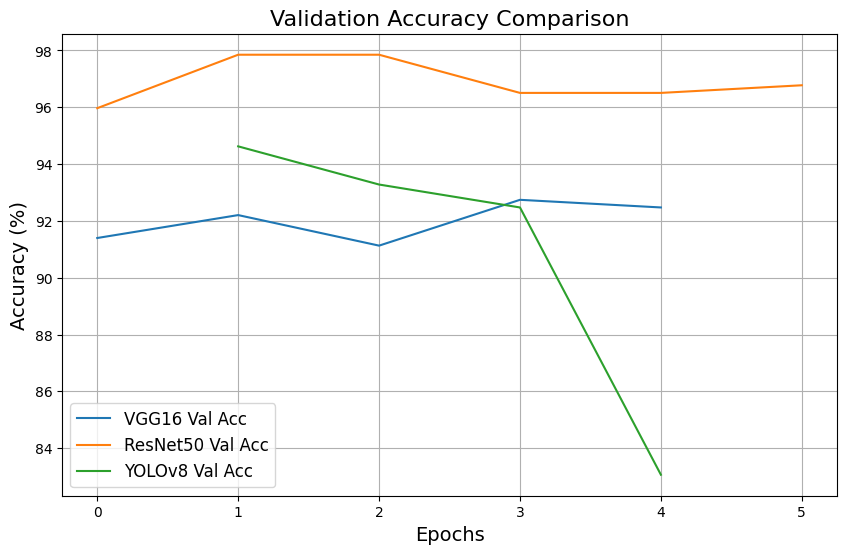

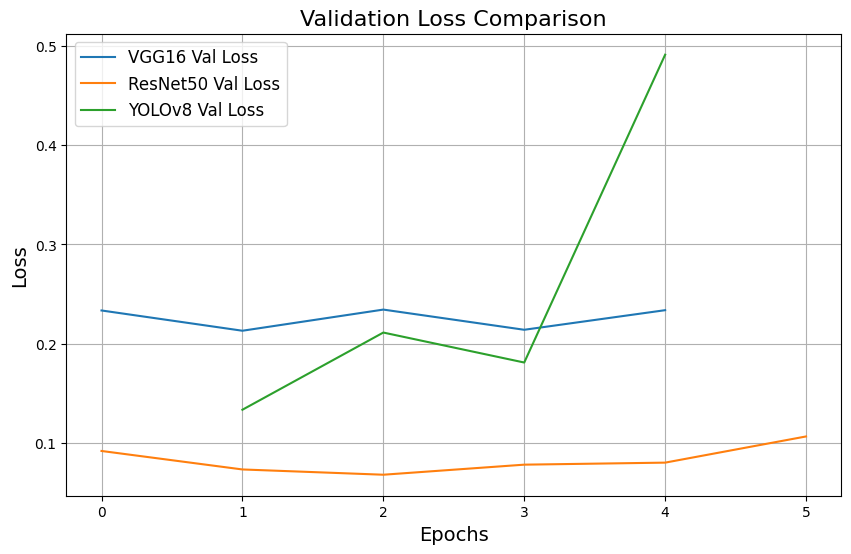


--- VGG16 Test Report ---
                  precision    recall  f1-score   support

    Malnourished       0.87      1.00      0.93        88
Not Malnourished       1.00      0.87      0.93        98

        accuracy                           0.93       186
       macro avg       0.94      0.93      0.93       186
    weighted avg       0.94      0.93      0.93       186


--- ResNet50 Test Report ---
                  precision    recall  f1-score   support

    Malnourished       0.94      0.92      0.93        88
Not Malnourished       0.93      0.95      0.94        98

        accuracy                           0.94       186
       macro avg       0.94      0.93      0.94       186
    weighted avg       0.94      0.94      0.94       186



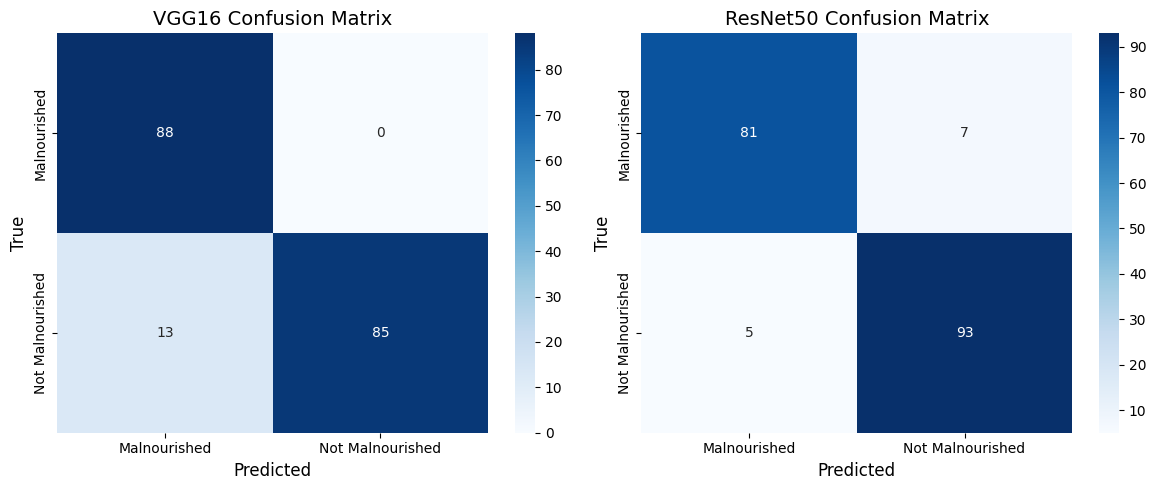

In [ ]:
# For CNN models
histories = [vgg_metrics, resnet_metrics]
labels = ['VGG16', 'ResNet50']

# For YOLOv8
results_path = '/content/runs/classify/train/results.csv'
yolov8_results = pd.read_csv(results_path)
yolov8_label = 'YOLOv8'

compare_models(histories, labels, yolov8_results, yolov8_label, class_names=['Malnourished', 'Not Malnourished'])

In [ ]:
!mv /content/runs /content/drive/MyDrive/data/results/yolov8/runs